<a href="https://colab.research.google.com/github/reedmarkham/meter-made/blob/main/meter_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library imports, etc.

In [126]:
import datetime
import itertools

from google.colab import drive
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import geopandas as gpd
import folium
import branca.colormap as cm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import lightgbm as lgb
import seaborn as sns

In [127]:
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load the DC parking data previously downloaded to Google Drive

In [128]:
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/dc-parking-data'

Mounted at /content/drive
Accessible_Parking_Zones.geojson
Address_Points.geojson
Parking_Blockface.geojson
Parking_Violations_Issued_in_April_2024.geojson
Parking_Violations_Issued_in_August_2024.geojson
Parking_Violations_Issued_in_December_2024.geojson
Parking_Violations_Issued_in_February_2024.geojson
Parking_Violations_Issued_in_January_2024.geojson
Parking_Violations_Issued_in_July_2024.geojson
Parking_Violations_Issued_in_June_2024.geojson
Parking_Violations_Issued_in_March_2024.geojson
Parking_Violations_Issued_in_May_2024.geojson
Parking_Violations_Issued_in_November_2024.geojson
Parking_Violations_Issued_in_October_2024.geojson
Parking_Violations_Issued_in_September_2024.geojson
Parking_Zones.geojson
Residential_and_Visitor_Parking_Zones.geojson
Roadway_Blockface.geojson
Street_Right_Of_Way.geojson
Valet_Parking.geojson


# Check out the DC street sweeping routes

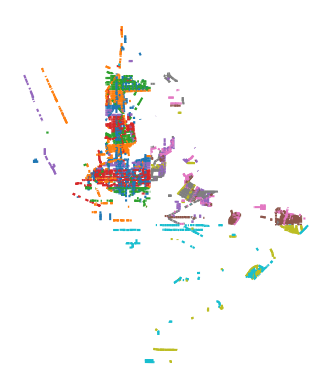

In [129]:
zones = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Zones.geojson')
ax = zones[zones.PARKINGGROUP == 'Sweeping'].plot(column='ROUTEID')
ax.set_axis_off()

# Ingest addresses and routes

In [130]:
addresses = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Address_Points.geojson')
a_cols = ['ADDRESS', 'ZIPCODE', 'BLOCKKEY', 'ROUTEID', 'LATITUDE', 'LONGITUDE']
addresses = addresses[a_cols]

# & (gdf.ROUTEID == '11072862')
routes = zones[(zones.PARKINGGROUP == 'Sweeping') & (zones.PARKINGDAYGROUP == 'Monday') & (zones.PARKINGHOURGROUP == 'AM')].set_crs('EPSG:4326')
routes = routes.sort_values(by='MEAS_FROM')
r_cols = ['ROUTEID', 'ZONEID', 'SIGNS', 'SIGNTEXT', 'SIGNCODE', 'MEAS_FROM', 'MEAS_TO', 'STARTTIME', 'ENDTIME', 'BLOCKFACEKEY', 'geometry']
routes = routes[r_cols]

routes_df = routes.merge(addresses, on='ROUTEID', how='inner')
routes_gdf = gpd.GeoDataFrame(
    routes_df,
    geometry=gpd.points_from_xy(routes_df.LONGITUDE, routes_df.LATITUDE),
    crs='EPSG:4326'
)

display(routes_gdf.sort_values(by='ADDRESS'))

,ROUTEID,ZONEID,SIGNS,SIGNTEXT,SIGNCODE,MEAS_FROM,MEAS_TO,STARTTIME,ENDTIME,BLOCKFACEKEY,geometry,ADDRESS,ZIPCODE,BLOCKKEY,LATITUDE,LONGITUDE
162405,11068382,b17df5ba43d9090d7fb1c6888ad5710c-left-1,"69707B76,9406DFDD",,R-NS-022,2436.798096,2517.250244,23.0,31.0,b17df5ba43d9090d7fb1c6888ad5710c,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
174799,11068382,5a1ef58455d9e8f59882cd6be3db8cec-left-0,"6C18511A,B49A4FF8,06C552E7,D85114EC",None,R-NS-022,2589.184814,2700.219482,23.0,31.0,5a1ef58455d9e8f59882cd6be3db8cec,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
223608,11068382,b29d88b46d5cd801e5007dc09163857f-right-2,"C4A733FA,E70DB290,2A48C50B,1FB37F0B,430D2FE0",,R-NS-022,3543.365479,3701.366455,23.0,31.0,b29d88b46d5cd801e5007dc09163857f,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
157253,11068382,84cf5ad23b44a52bbab608c63339bc8e-left-1,"BDA72933,74D960FB",,R-NS-022,2336.048096,2425.520508,23.0,31.0,84cf5ad23b44a52bbab608c63339bc8e,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
171602,11068382,46a76de4c58cce77f347c18c4d4d3525-left-0,DB9F1379,,R-NS-022,2529.746826,2576.688232,23.0,31.0,46a76de4c58cce77f347c18c4d4d3525,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312150,11000902,0fbbc26c002e9b0bc4e6092049110bdb-left-1,"FB648B3A,D193CC03",,R-NS-022,7060.233398,7100.389648,23.0,31.0,0fbbc26c002e9b0bc4e6092049110bdb,POINT (-77.02397 38.88975),None,20004.0,ea6918a50e1295d78553a3d6f022e8b5,38.889749,-77.023974
312340,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234
312968,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02923 38.96446),None,20011.0,c2d1955d497def9cef4c8fdb1230459d,38.964463,-77.029228
313250,11001302,19988afe7a283be8f02099b1b4f7a904-right-1,"C21C8818,D35B104F",,R-NS-022,7170.645020,7207.974609,23.0,31.0,19988afe7a283be8f02099b1b4f7a904,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234


# Ingest tickets

In [131]:
t_jan = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_January_2024.geojson')
t_feb = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_February_2024.geojson')
t_mar = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_March_2024.geojson')
t_apr = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_April_2024.geojson')
t_may = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_May_2024.geojson')
t_jun = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_June_2024.geojson')
t_jul = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_July_2024.geojson')
t_aug = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_August_2024.geojson')
t_sep = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_September_2024.geojson')
t_oct = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_October_2024.geojson')
t_nov = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_November_2024.geojson')
t_dec = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_December_2024.geojson')
t = pd.concat([t_jan, t_feb, t_mar, t_apr, t_may, t_jun, t_jul, t_aug, t_sep, t_oct, t_nov, t_dec])

tickets = gpd.GeoDataFrame(
    t,
    geometry=gpd.points_from_xy(t.LONGITUDE, t.LATITUDE),
    crs="EPSG:4326"
)

# Fill NaN values in VIOLATION_PROC_DESC with an empty string before using .str.contains()
tickets['VIOLATION_PROC_DESC'] = tickets['VIOLATION_PROC_DESC'].fillna('')
display(tickets[tickets.VIOLATION_PROC_DESC.str.contains('EXPIRED METER')])

,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,VIOLATION_PROC_DESC,LOCATION,...,PENALTY_4,PENALTY_5,XCOORD,YCOORD,LATITUDE,LONGITUDE,MAR_ID,GIS_LAST_MOD_DTTM,geometry,VIOLATION_TYPE_DESC
87,82674490,280396852,2024-01-11 05:00:00+00:00,1210,22,UNITED STATES PARK POLICE,USPP,P039,PARK AT EXPIRED METER,1300 CONSTITUTION AVE NW,...,0,0,397393.00,136027.41,38.892,-77.030,809504.0,2024-02-16 15:03:41+00:00,POINT (-77.03 38.892),NaN
236,82674844,291813130,2024-01-02 05:00:00+00:00,925,57,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,550 GALLOWAY ST NE,...,0,0,399797.55,142700.05,38.952,-77.002,294852.0,2024-02-16 15:03:41+00:00,POINT (-77.002 38.952),NaN
237,82674845,291813141,2024-01-02 05:00:00+00:00,926,57,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,550 GALLOWAY ST NE,...,0,0,399797.55,142700.05,38.952,-77.002,294852.0,2024-02-16 15:03:41+00:00,POINT (-77.002 38.952),NaN
238,82674846,291813152,2024-01-02 05:00:00+00:00,930,57,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,550 GALLOWAY ST NE,...,0,0,399797.55,142700.05,38.952,-77.002,294852.0,2024-02-16 15:03:41+00:00,POINT (-77.002 38.952),NaN
239,82674847,291813174,2024-01-02 05:00:00+00:00,937,57,METRO POLICE,MTP,P039,PARK AT EXPIRED METER,550 GALLOWAY ST NE,...,0,0,399797.55,142700.05,38.952,-77.002,294852.0,2024-02-16 15:03:41+00:00,POINT (-77.002 38.952),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73224,83855861,8274778750,2024-12-31 05:00:00+00:00,954,15,DEPARTMENT OF PUBLIC WORKS,DPW,P039,PARK AT EXPIRED METER,2200 BLOCK EYE ST NW NORTH SIDE,...,0,0,395708.30,136984.04,38.901,-77.049,800361.0,2025-01-16 15:04:52+00:00,POINT (-77.049 38.901),P
73225,83855862,8274778761,2024-12-31 05:00:00+00:00,956,15,DEPARTMENT OF PUBLIC WORKS,DPW,P039,PARK AT EXPIRED METER,2200 BLOCK EYE ST NW NORTH SIDE,...,0,0,395708.30,136984.04,38.901,-77.049,800361.0,2025-01-16 15:04:52+00:00,POINT (-77.049 38.901),P
73251,83855888,8274779026,2024-12-31 05:00:00+00:00,1133,15,DEPARTMENT OF PUBLIC WORKS,DPW,P039,PARK AT EXPIRED METER,2100 BLOCK H ST NW NORTH SIDE,...,0,0,395858.43,136859.43,38.900,-77.048,810340.0,2025-01-16 15:04:52+00:00,POINT (-77.048 38.9),P
73252,83855889,8274779030,2024-12-31 05:00:00+00:00,1135,15,DEPARTMENT OF PUBLIC WORKS,DPW,P039,PARK AT EXPIRED METER,2100 BLOCK H ST NW NORTH SIDE,...,0,0,395858.43,136859.43,38.900,-77.048,810340.0,2025-01-16 15:04:52+00:00,POINT (-77.048 38.9),P


# Join street cleaning parking tickets with sweeping routes

In [132]:
routes_gdf.geometry = routes_gdf.geometry.set_precision(grid_size=0.0001).force_2d()
cleaning_tix = tickets[tickets.VIOLATION_CODE == 'P173']
cleaning_tix.geometry = cleaning_tix.geometry.set_precision(grid_size=0.0001).force_2d()
tickets_and_routes = gpd.sjoin(routes_gdf, cleaning_tix, how='inner', predicate='intersects')
tickets_and_routes = tickets_and_routes[['TICKET_NUMBER', 'ROUTEID', 'ISSUE_DATE', 'ISSUE_TIME', 'geometry']]
tickets_and_routes = tickets_and_routes.sort_values(by='TICKET_NUMBER').drop_duplicates()
tickets_and_routes.geometry = tickets_and_routes.geometry.set_precision(grid_size=0.00001)
display(tickets_and_routes)

/usr/local/lib/python3.11/dist-packages/shapely/_geometry.py:814: RuntimeWarning: invalid value encountered in set_precision
  return lib.set_precision(geometry, grid_size, np.intc(mode), **kwargs)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,TICKET_NUMBER,ROUTEID,ISSUE_DATE,ISSUE_TIME,geometry
79027,8243710904,11090152,2024-04-09 04:00:00+00:00,1256,POINT (-77.011 38.919)
83229,8243710915,11090152,2024-04-09 04:00:00+00:00,1259,POINT (-77.011 38.919)
86017,8243710926,11090152,2024-04-09 04:00:00+00:00,1300,POINT (-77.011 38.919)
124964,8259953855,11088462,2024-04-15 04:00:00+00:00,1007,POINT (-77.04 38.918)
146212,8259953870,11088462,2024-04-15 04:00:00+00:00,1016,POINT (-77.04 38.918)
...,...,...,...,...,...
22590,8272658796,11033862,2024-10-28 04:00:00+00:00,1109,POINT (-77.04 38.923)
300426,8272691055,11001302,2024-10-28 04:00:00+00:00,955,POINT (-77.03 38.928)
15749,8272715861,11025932,2024-10-24 04:00:00+00:00,1050,POINT (-77.031 38.912)
190875,8272771791,11063182,2024-10-29 04:00:00+00:00,939,POINT (-77.033 38.907)


In [133]:
tickets_and_routes['timestamp'] = tickets_and_routes.apply(
    lambda row: str(row['ISSUE_DATE'].date()) + ' ' + row['ISSUE_TIME'],
    axis=1
    )
tickets_and_routes['timestamp'] = pd.to_datetime(
    tickets_and_routes['timestamp'],
    format='%Y-%m-%d %H%M',
    errors='coerce'
    )
tickets_and_routes = tickets_and_routes[['geometry', 'ROUTEID', 'timestamp']]
display(tickets_and_routes)

,geometry,ROUTEID,timestamp
79027,POINT (-77.011 38.919),11090152,2024-04-09 12:56:00
83229,POINT (-77.011 38.919),11090152,2024-04-09 12:59:00
86017,POINT (-77.011 38.919),11090152,2024-04-09 13:00:00
124964,POINT (-77.04 38.918),11088462,2024-04-15 10:07:00
146212,POINT (-77.04 38.918),11088462,2024-04-15 10:16:00
...,...,...,...
22590,POINT (-77.04 38.923),11033862,2024-10-28 11:09:00
300426,POINT (-77.03 38.928),11001302,2024-10-28 09:55:00
15749,POINT (-77.031 38.912),11025932,2024-10-24 10:50:00
190875,POINT (-77.033 38.907),11063182,2024-10-29 09:39:00


# Visualize frequency and order (by ticket timestamp) of parking tickets along routes

In [134]:
DC_COORDS = [38.90720, -77.03690]

tickets_and_routes_filtered = tickets_and_routes[
    tickets_and_routes['timestamp'].dt.date == pd.to_datetime('2024-10-28').date()
]

map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

#TO-DO: compute elapsed_minutes within ROUTEID as well as colormap but then plot for each ROUTEID layer the respective colormap and elapsed_minutes in popup ("since street cleaning route started")

tickets_and_routes_filtered['elapsed_minutes'] = (tickets_and_routes_filtered['timestamp'] - tickets_and_routes_filtered['timestamp'].min()).dt.total_seconds() / 60

colormap = cm.linear.Blues_03.scale(
    tickets_and_routes_filtered.elapsed_minutes.min(),
    tickets_and_routes_filtered.elapsed_minutes.max()
    )

geometry_counts = tickets_and_routes_filtered.groupby(['geometry', 'ROUTEID'])['timestamp'].count().reset_index()
earliest_timestamps = tickets_and_routes_filtered.groupby(['geometry', 'ROUTEID'])['timestamp'].min().rename('earliest_timestamp').reset_index()

route_layers = {}
for route_id in tickets_and_routes_filtered['ROUTEID'].unique():
  route_data = tickets_and_routes_filtered[tickets_and_routes_filtered['ROUTEID'] == route_id]
  route_fg = folium.FeatureGroup(name=f"Route {route_id}")

  for idx, row in route_data.sort_values(by='elapsed_minutes').iterrows():
      lon = row.geometry.x
      lat = row.geometry.y
      count_for_geometry = int(geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].iloc[0] if geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].size > 0 else 0)
      earliest_timestamp = earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].iloc[0] if earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].size > 0 else None

      popup_html = f"""
      <h1> Street sweeping summary:</h1>
      <p># of tickets: {count_for_geometry}</p>
      <p>Started at: {earliest_timestamp}</p>
      """

      folium.CircleMarker(
          location=[lat, lon],
          radius=count_for_geometry,
          color='none',
          fill=True,
          fill_color=colormap(row.elapsed_minutes),
          fill_opacity=0.7,
          popup=popup_html
      ).add_to(route_fg)

  route_layers[route_id] = route_fg
  route_fg.add_to(map)


colormap.add_to(map)
folium.LayerControl().add_to(map)

map

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Compute clusters of expired parking meter ticket locations (x, y coords)

In [135]:
tix = tickets[tickets.VIOLATION_CODE == 'P039']

array_data = []
for index, row in tix.iterrows():
  if row.geometry and row.geometry.is_valid and not row.geometry.is_empty:
    x_coord = row.geometry.x
    y_coord = row.geometry.y
    date = row['ISSUE_DATE'].date()

    try:
        time_of_day = datetime.time(int(row['ISSUE_TIME'].zfill(4)[:2]), int(row['ISSUE_TIME'].zfill(4)[2:]))
    except (ValueError, TypeError):
        print(f"Invalid time format: {row['ISSUE_TIME']}, skipping row")
        continue

    #day_of_week =  row['ISSUE_DATE'].date().isoweekday()
    array_data.append([x_coord, y_coord, date, time_of_day])

X_full = np.array(array_data)
X_full_df = pd.DataFrame(X_full, columns=['x', 'y', 'd', 't'])
X_full_df['h'] = X_full_df['t'].apply(lambda t: (t.hour + (t.minute + 30) // 60) % 24)
X_full = X_full_df.values
display(pd.DataFrame(X_full, columns=['x', 'y', 'd', 't', 'h']))

,x,y,d,t,h
0,-77.03,38.892,2024-01-11,12:10:00,12
1,-77.002,38.952,2024-01-02,09:25:00,9
2,-77.002,38.952,2024-01-02,09:26:00,9
3,-77.002,38.952,2024-01-02,09:30:00,10
4,-77.002,38.952,2024-01-02,09:37:00,10
...,...,...,...,...,...
38950,-77.049,38.901,2024-12-31,09:54:00,10
38951,-77.049,38.901,2024-12-31,09:56:00,10
38952,-77.048,38.9,2024-12-31,11:33:00,12
38953,-77.048,38.9,2024-12-31,11:35:00,12


In [167]:
to_cluster = pd.DataFrame(X_full, columns=['x', 'y', 'd', 't', 'h'])

In [187]:
# prompt: using to_cluster compute DBSCAN clusters in a function that filters to_cluster for given d and h

import pandas as pd
from sklearn.cluster import DBSCAN

def compute_dbscan_clusters(to_cluster, d, h):
  """Computes DBSCAN clusters for a given date and hour.

  Args:
    to_cluster: A pandas DataFrame with columns 'x', 'y', 'd', 't', 'h'.
    d: The date to filter for.
    h: The hour to filter for.

  Returns:
    A pandas DataFrame with columns 'x', 'y', 'cluster', containing the clustered
    data for the specified date and hour.
  """
  filtered_data = to_cluster[(to_cluster['d'] == d) & (to_cluster['h'] == h)][['x', 'y']]
  if filtered_data.empty:
    return pd.DataFrame(columns=['x', 'y', 'cluster'])
  db = DBSCAN(eps=0.01, min_samples=5).fit(filtered_data)
  labels = db.labels_
  core = db.core_sample_indices_
  clustered_data = filtered_data.copy()
  clustered_data['cluster'] = labels
  return clustered_data

compute_dbscan_clusters(to_cluster, datetime.date(2024, 6, 25), 11)

,x,y,cluster
19697,-77.04,38.897,0
19698,-77.04,38.897,0
20952,-77.042,38.898,0
21161,-77.02,38.887,-1
21270,-77.05,38.903,0
21417,-77.038,38.907,0
21418,-77.038,38.907,0
21419,-77.037,38.907,-1
21497,-77.008,38.899,1
21498,-77.008,38.899,1


In [203]:
# prompt: plot the above clusters

# Assuming 'compute_dbscan_clusters' function is defined as in the provided code

import folium

DC_COORDS = [38.90720, -77.03690]
map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

date_to_plot = datetime.date(2024, 6, 25)
hour_to_plot = 11

clustered_data = compute_dbscan_clusters(to_cluster, date_to_plot, hour_to_plot)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige']

if not clustered_data.empty:
  for (cluster_id, color_) in zip(clustered_data['cluster'].unique(), colors):
    if cluster_id == -1:  # Noise points
      continue

    cluster_points = clustered_data[clustered_data['cluster'] == cluster_id]
    if not cluster_points.empty:
      for _, cp in cluster_points.iterrows():
        # Plot clusters on the map
        folium.CircleMarker(
            location=[cp['y'], cp['x']],
            radius=3,
            color=color_,
            fill=True,
            fill_color=color_,
            fill_opacity=0.7,
            popup=f"Cluster {cluster_id}"
        ).add_to(map)

map


In [137]:
# prompt: Write a function that filters X_full_df for values of d and h. Then compute k-means clusters centroids within the filtered data. Print the results in an example function call

def compute_kmeans_cluster_centers(X_full, d, h):
  """
  Filters X_full by d and h, and then computes centers of k-mean clusters (k=8) in the result dataset.

  Args:
    X_full: A NumPy array with columns [x, y, d, t, h].
    d: The date to filter by.
    h: The hour to filter by.

  Returns:
    A list of cluster center coordinates for the filtered data.
  """
  X_filtered = X_full[(X_full[:, 2] == d) & (X_full[:, 4] == h)]
  if len(X_filtered) > 0:
    n_clusters = min(len(X_filtered), 6)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_filtered[:, :2])  # Fit on x, y coordinates
    return kmeans.cluster_centers_
  else:
    return []


# Example function call
example_date = datetime.date(2024, 6, 25)
example_hour = 11
cluster_centers = compute_kmeans_cluster_centers(X_full, example_date, example_hour)

# Check if cluster_centers is not empty instead of directly evaluating its truthiness
if len(cluster_centers) > 0: # Changed this line to check if the cluster_centers array is not empty using len()
  print(f"Cluster centers for date {example_date} and hour {example_hour}:")
  for center in cluster_centers:
    print(center)
else:
  print(f"No data found for date {example_date} and hour {example_hour}.")

Cluster centers for date 2024-06-25 and hour 11:
[-77.008  38.899]
[-76.995  38.865]
[-77.05   38.903]
[-77.03766667  38.907     ]
[-77.02   38.887]
[-77.04066667  38.89733333]


In [138]:
# Generate all possible (d, h) combinations
combinations = list(itertools.product(X_full_df['d'].unique(), X_full_df['h'].unique()))

# Initialize an empty list to store cluster centers for each (d, h)
cluster_centers_list = []

# Loop through each (d, h) combination
for d, h in combinations:
  # Compute cluster centers for the current (d, h)
  cluster_centers = compute_kmeans_cluster_centers(X_full, d, h)

  # Append the cluster centers and (d, h) to the list
  if len(cluster_centers) > 0:
    for center in cluster_centers:
      cluster_centers_list.append([d, h, *center])

# Create a DataFrame from the list of cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers_list, columns=['d', 'h', 'cluster_x', 'cluster_y'])

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:

# We will preprocess the data a bit, by filling out "incomplete" clusters with the average of the preceding clusters

In [139]:
# Group by (d, h) and count the number of coordinate pairs
coordinate_counts = cluster_centers_df.groupby(['d', 'h']).count().reset_index()
filtered_df = coordinate_counts[coordinate_counts.cluster_x < 6][['d', 'h']]
display(filtered_df)

,d,h
1,2024-01-02,9
9,2024-01-02,17
10,2024-01-02,20
11,2024-01-03,0
12,2024-01-03,8
...,...,...
3841,2024-12-30,21
3842,2024-12-31,7
3846,2024-12-31,11
3849,2024-12-31,15


In [140]:
cluster_centers_df['cluster_coords'] = list(zip(cluster_centers_df.cluster_x, cluster_centers_df.cluster_y))
cluster_centers_df = cluster_centers_df.groupby(['d', 'h'])['cluster_coords'].apply(list).reset_index(name='coords_array')
display(cluster_centers_df)

,d,h,coords_array
0,2024-01-02,8,"[(-77.074, 38.914), (-77.026, 38.903), (-77.07..."
1,2024-01-02,9,"[(-77.003, 38.904), (-77.002, 38.952), (-77.00..."
2,2024-01-02,10,"[(-77.0456, 38.8989), (-77.002, 38.952), (-77...."
3,2024-01-02,11,"[(-77.06299999999999, 38.90775), (-77.002, 38...."
4,2024-01-02,12,"[(-77.041, 38.898), (-77.018, 38.975), (-77.01..."
...,...,...,...
3846,2024-12-31,11,"[(-77.042, 38.899), (-77.011, 38.894)]"
3847,2024-12-31,12,"[(-77.019, 38.878454545454545), (-77.049571428..."
3848,2024-12-31,13,"[(-77.033, 38.915), (-77.046, 38.901), (-77.04..."
3849,2024-12-31,15,"[(-77.047, 38.898), (-77.047, 38.898)]"


In [141]:
def pad_coords_array(coords_array):
  """Pads the coords_array to 6 members with the average of the original members.

  Args:
    coords_array: A list of coordinate tuples.

  Returns:
    A list of coordinate tuples with 6 members.
  """

  if not isinstance(coords_array, list) or len(coords_array) == 0:
    return [[0,0]] * 6

  num_coords = len(coords_array)
  if num_coords >= 6:
    return coords_array[:6]
  else:
    avg_x = np.mean([coord[0] for coord in coords_array])
    avg_y = np.mean([coord[1] for coord in coords_array])
    padded_array = coords_array + [(avg_x, avg_y)] * (6 - num_coords)
    return padded_array

In [142]:
final_df = cluster_centers_df[cluster_centers_df.d.isin(filtered_df.d) & cluster_centers_df.h.isin(filtered_df.h)]
final_df['coords_array'] = final_df['coords_array'].parallel_apply(pad_coords_array)
display(final_df)
# Here we end up padding 37% of input parking ticket arrays

<ipython-input-142-91beea9935bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['coords_array'] = final_df['coords_array'].parallel_apply(pad_coords_array)


,d,h,coords_array
0,2024-01-02,8,"[(-77.074, 38.914), (-77.026, 38.903), (-77.07..."
1,2024-01-02,9,"[(-77.003, 38.904), (-77.002, 38.952), (-77.00..."
2,2024-01-02,10,"[(-77.0456, 38.8989), (-77.002, 38.952), (-77...."
3,2024-01-02,11,"[(-77.06299999999999, 38.90775), (-77.002, 38...."
4,2024-01-02,12,"[(-77.041, 38.898), (-77.018, 38.975), (-77.01..."
...,...,...,...
3846,2024-12-31,11,"[(-77.042, 38.899), (-77.011, 38.894), (-77.02..."
3847,2024-12-31,12,"[(-77.019, 38.878454545454545), (-77.049571428..."
3848,2024-12-31,13,"[(-77.033, 38.915), (-77.046, 38.901), (-77.04..."
3849,2024-12-31,15,"[(-77.047, 38.898), (-77.047, 38.898), (-77.04..."


# Predict parking ticket cluster locations using LightGBM

In [143]:
def expand_coords_array(row):
  arr = row['coords_array']
  if arr is not None:
    for i in range(6):
      row[f'x{i+1}'] = arr[i][0]
      row[f'y{i+1}'] = arr[i][1]
  return row

final_df = final_df.parallel_apply(expand_coords_array, axis=1)
display(final_df.drop(columns=['coords_array']))

,d,h,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6
0,2024-01-02,8,-77.0740,38.914000,-77.026000,38.903000,-77.076000,38.9130,-77.076000,38.914000,-77.07400,38.9130,-77.07400,38.9140
1,2024-01-02,9,-77.0030,38.904000,-77.002000,38.952000,-77.002000,38.8870,-77.003000,38.904000,-77.00300,38.9040,-77.00260,38.9102
2,2024-01-02,10,-77.0456,38.898900,-77.002000,38.952000,-77.004000,38.8870,-77.030667,38.905667,-77.06300,38.9080,-77.04800,38.9070
3,2024-01-02,11,-77.0630,38.907750,-77.002000,38.952000,-77.041333,38.8980,-77.023000,38.927000,-77.05025,38.9000,-77.04400,38.8938
4,2024-01-02,12,-77.0410,38.898000,-77.018000,38.975000,-77.019000,38.8790,-77.063000,38.908000,-77.05000,38.9030,-77.04375,38.8955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,2024-12-31,11,-77.0420,38.899000,-77.011000,38.894000,-77.026500,38.8965,-77.026500,38.896500,-77.02650,38.8965,-77.02650,38.8965
3847,2024-12-31,12,-77.0190,38.878455,-77.049571,38.898857,-77.074000,38.9140,-77.054000,38.904000,-77.00800,38.8990,-77.04225,38.9005
3848,2024-12-31,13,-77.0330,38.915000,-77.046000,38.901000,-77.043000,38.9110,-77.033000,38.916000,-77.03300,38.9150,-77.03300,38.9150
3849,2024-12-31,15,-77.0470,38.898000,-77.047000,38.898000,-77.047000,38.8980,-77.047000,38.898000,-77.04700,38.8980,-77.04700,38.8980


In [144]:
# Prepare the data
X = final_df[['d', 'h']]
y = final_df[['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']]

# Convert date to numerical representation (e.g., days since epoch)
X['d'] = pd.to_datetime(X['d']).astype(int) / 10**9

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM multi-output regressor
model = MultiOutputRegressor(estimator=lgb.LGBMRegressor())

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model (e.g., using metrics like R2 score or Mean Squared Error)
print(r2_score(y_test, y_pred, multioutput='raw_values'))
print(r2_score(y_test, y_pred, multioutput='uniform_average'))

<ipython-input-144-d1d67f809e06>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['d'] = pd.to_datetime(X['d']).astype(int) / 10**9


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 3056, number of used features: 2
[LightGBM] [Info] Start training from score -77.041514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 3056, number of used features: 2
[LightGBM] [Info] Start training from score 38.912628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 3056, number of used features: 2
[LightGBM] [Info] Start training 

# Predict parking ticket cluster locations using Long Short-Term Memory (LSTM)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [146]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [147]:
# Generate all possible dates and hours for 2024
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 12, 31)
all_dates = [start_date + datetime.timedelta(days=x) for x in range((end_date - start_date).days + 1)]
all_hours = list(range(24))

# Create a DataFrame with all possible (d, h) combinations for 2024
all_combinations = list(itertools.product(all_dates, all_hours))
all_combinations_df = pd.DataFrame(all_combinations, columns=['d', 'h'])

# Merge with existing DataFrame X and fill missing values with 0
X_expanded = pd.merge(all_combinations_df, X, on=['d', 'h'], how='left')
X_expanded['d'] = pd.to_datetime(X_expanded['d']).astype(int) / 10**9
X_expanded = X_expanded.fillna(0)

In [148]:
X_expanded_filtered = X_expanded[~X_expanded['d'].isin(X['d']) | ~X_expanded['h'].isin(X['h'])]
display(X_expanded_filtered)

,d,h
0,1.704067e+09,0
1,1.704067e+09,1
2,1.704067e+09,2
3,1.704067e+09,3
4,1.704067e+09,4
...,...,...
8742,1.735517e+09,6
8761,1.735603e+09,1
8764,1.735603e+09,4
8765,1.735603e+09,5


In [149]:
X = pd.concat([X, X_expanded_filtered], axis=0)

new_y = pd.DataFrame(np.zeros(X_expanded_filtered.shape[0]), columns=['y'])
y = pd.concat([y, new_y], axis=0)

In [150]:
X['d'] = pd.to_datetime(X['d']).apply(lambda x: x.toordinal())
dataset = X.values
dataset = dataset.astype('float32')

In [151]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [152]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4425 2180


In [153]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [154]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [155]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [164]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=2, verbose=2)

Epoch 1/5
2212/2212 - 8s - 4ms/step - loss: 0.0000e+00
Epoch 2/5
2212/2212 - 7s - 3ms/step - loss: 0.0000e+00
Epoch 3/5
2212/2212 - 8s - 4ms/step - loss: 0.0000e+00
Epoch 4/5
2212/2212 - 6s - 3ms/step - loss: 0.0000e+00
Epoch 5/5
2212/2212 - 10s - 4ms/step - loss: 0.0000e+00


In [165]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(np.concatenate([trainPredict, np.zeros_like(trainPredict)], axis=1))[:, 0]
testPredict = scaler.inverse_transform(np.concatenate([testPredict, np.zeros_like(testPredict)], axis=1))[:, 0]
testY = scaler.inverse_transform(np.concatenate([testY.reshape(-1, 1), np.zeros_like(testY.reshape(-1, 1))], axis=1))[:, 0]

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print(f'Train Score: {trainScore} RMSE')

testScore = np.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore} RMSE')

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 719163.0079029371 RMSE
Test Score: 0.0 RMSE


# A heuristic to predict parking tickets from day, time, and cluster locations

In [ ]:
# Filter for the specified date and hour
filtered_df = cluster_centers_df[(cluster_centers_df['d'] == pd.to_datetime('2024-06-25').date()) & (cluster_centers_df['h'] == 11)]

# Explode coords_array into cluster_x and cluster_y
exploded_df = filtered_df.explode('coords_array')
exploded_df[['cluster_x', 'cluster_y']] = pd.DataFrame(exploded_df['coords_array'].tolist(), index=exploded_df.index)

test_clusters_gdf = gpd.GeoDataFrame(
    exploded_df,
    geometry=gpd.points_from_xy(exploded_df.cluster_x, exploded_df.cluster_y),
    crs='EPSG:4326'
)
test_clusters_gdf = test_clusters_gdf.to_crs('EPSG:32618')
display(test_clusters_gdf.geometry)

In [ ]:
addresses_gdf = gpd.GeoDataFrame(
    addresses,
    geometry=gpd.points_from_xy(addresses.LONGITUDE, addresses.LATITUDE),
    crs='EPSG:4326'
)

print(addresses_gdf.estimate_utm_crs())

addresses_gdf = addresses_gdf.to_crs('EPSG:32618')
display(addresses_gdf)

In [ ]:
a_gdf = addresses_gdf[['ADDRESS', 'geometry']]
a_gdf['min_dist'] = a_gdf.parallel_apply(lambda row: row.geometry.distance(test_clusters_gdf.geometry).min()/1609.34, axis=1)
display(a_gdf)

In [ ]:
def estimate_ticket(dist):
  return 1 if dist < 0.25 else 0

a_gdf['ticketed'] = a_gdf['min_dist'].parallel_apply(estimate_ticket)
a_gdf.plot(column='ticketed')